# Probabilistic Seismic Hazard Analysis (PSHA)

Probabilistic seismic hazard analysis (PSHA) is the determination and evaluation of seismic hazard (that is can be of the form of peak ground acceleration) on a specific project site. A seismic hazard is defined as the exceedance probability for a given ground motion intensity measures, site and time interval. The results of seismic hazard analysis of small scale buildings are already incorporated in seismic design in building codes while other large scale or special structures may require site specific PSHA. A comprehensive guidance on the procedure is given in [SHAAC (1997)](https://www.nrc.gov/reading-rm/doc-collections/nuregs/contract/cr6372/vol1/index.html).

## General Procedure

The procedure of the performing PSHA consists of 4 steps. Each of the procedure will be briefly discussed in this notebook through an example.
 1. Determine probability distribution of source-to-site distances, $f_{R}(r)$. The possible sources of earthquakes should be identified first either using Seismic Instrumental records, geologic evidences,  tectonic evidences or historical evidences. Seismicity maps with known faults can be used to determine possible sources of earthquakes.
 2. Develop a recurrence relationship model and a corresponding temporal earthquake size probability distribution, $f_M(m)$. A recurrence relationship law provides a quantitative description on the average rate that an earthquake of magnitude $m$ will be exceeded.
 3. Determine the ground motion at the site produced by ***(a)*** earthquakes of any probable size (magnitude) and ***(b)*** from any possible source zone using Ground Motion Prediction Equations.
 4. Determine the exceedance rate of a speific ground motion parameter (i.e. PGA, PGV etc.) by combining the uncertainties in the earthquake location (step 1), earthquake size/magnitude (step 2) and ground motion (step 3).




## Simple PSHA Example 

The seismic hazard for a specific site is to be evaluated. It is assumed that a single ***point source*** 40 km away is the contributing potential source of earthquake. The recurrence relationship for this point is assumed to be $a=2$ and $b=1$. The local soil condition has $V_{S30}=760~m/s$. The illustration is shown below.

<img src="problem_description.png" width="300">




### Step 1: Spatial Uncertainty

Once the project site location is already established, the possible sources of the earthquakes should be identified. There available fault maps [GEM Global Active Faults Database](https://github.com/cossatot/gem-global-active-faults) which could be possible sources of earthquakes.

Once the possible sources are identified the distribution of the site-to-source distances $f_R(r)$ should be established. An illustration below is shown on how to make this. For the case of point source, the distribution is given by $f_R(r')=\delta(r-r')$. Applying to the example, $P(R=30)=1.0$.

<img src="eq_sources.png" width="600">

In [1]:
# import some packages first
import numpy as np
from math import exp
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib_inline.backend_inline
ipython_format = 'svg'
if isinstance(ipython_format, str):
    ipython_format = [ipython_format]
matplotlib_inline.backend_inline.set_matplotlib_formats(*ipython_format)

plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('font', size=14)          # controls default text sizes
plt.rcParams["font.family"] = "tex"
mpl.rc('text', usetex='True') 

In [8]:
# define the distances and probability
dist = np.linspace(10,50,5)
prob = np.zeros((5))
prob[3] = 1

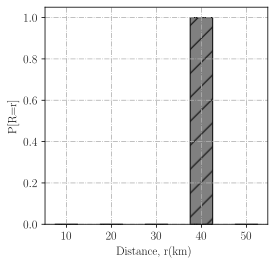

In [9]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4,4)
plt.bar(dist,prob,width=5,hatch="/",edgecolor='black',color='gray')
plt.ylabel('P[R=r]')
plt.xlabel('Distance, r(km)')
plt.grid(linestyle='-.')
plt.show()

### Step 2: Earthquake Size Uncertainty

The 

In [4]:
def calc_prob_M (ml,mu, m0,mmax, b):
    """
    This function calculates the probability that a certain magnitude earthquake between ml and mu will be exceeded.
    The recurrence law is based from Bounded Gutenberg-Richter.
    """
    # parameter in Bounded GR law
    beta = 2.303*b
    
    # average of the range of ml and mu
    m_ave = (ml+mu)/2.
    
    # probability distribution from Bounded Gutenberg-Richter Law
    fm = (beta*exp(-beta*(m_ave-m0)))/(1-exp(-beta*(mmax-m0)))
    
    # calculate the probability between range of ml and mu
    P_M = fm * (mu-ml)
    return P_M

In [19]:
# define ranges of magnitude
lower = np.array([4.5,5.5,6.5])
upper = np.array([5.499,6.499,7.499])

# define discrete value for ranges representing each range/bin 
magnitude = np.linspace(5,7,3)

prob_M = []
m0,mmax = 4.0,7.5
b = 2
for i in range(0,len(lower)):
    prob_M.append(calc_prob_M(lower[i],upper[i], m0,mmax, b))
prob_M = np.array(prob_M).reshape((len(magnitude),1))

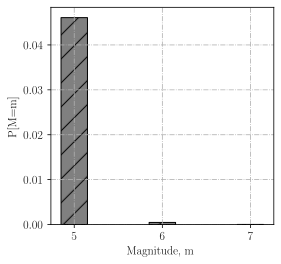

In [7]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4,4)
plt.bar(magnitude,prob_M,width=0.3,hatch="/",edgecolor='black',color='gray')
plt.ylabel('P[M=m]')
plt.xlabel('Magnitude, m')
plt.grid(linestyle='-.')
plt.xticks(np.arange(min(magnitude), max(magnitude)+1, 1.0))
plt.show()

### Step 3


In [11]:
def func(x,*params):
    median,sigma = params
    y = median - x/np.sqrt(1+(sigma/x)**2)
    return y

In [17]:
# Determine PGA median and media+sigma from NGAWest2 GMPE
# for the different values of m and r
pga_median = np.array([0.13988,0.07573,0.02755])
pga_median_plus_sigma = np.array([0.25708,0.14376,0.05834])

# Calculate the lognormal parameters of the ground intensity measure
# IM ~ LN(lambda,zeta) or ln(IM) ~ N(lambda,zeta)
pga_sigma = pga_median_plus_sigma - pga_median
lambda_param = np.log(pga_median).reshape((len(pga_median),1))
zeta_param = []
for i in range(0,len(pga_median)):
    mu = fsolve(func,0.1,args=(pga_median[i],pga_sigma[i]))
    cov = pga_sigma[i]/mu
    zeta_param.append(np.sqrt(np.log(1+cov**2)))
zeta_param = np.array(zeta_param).reshape((len(pga_median),1))

# Calculate the probability of P(IM > y*| m,r)
y_star = 0.05
prob_Y = []
for i in range(0,len(pga_median)):
    z = (np.log(y_star)-lambda_param[i]) / zeta_param[i]
    prob_Y.append(norm.cdf(-z))
    
prob_Y = np.array(prob_Y)
print(prob_Y)

[[0.95044232]
 [0.73811539]
 [0.20970022]]


### Step 4

In [20]:
# calculate lambda_y   
a,b =  2., 1.
alpha,beta = 2.303*a, 2.303*b
m0 = 4.0
nu = np.exp(alpha - beta*m0)
lambda_y_star = np.sum(nu*prob_M*prob_Y)
    
print(f'lambda_y_star = {lambda_y_star}')
    

lambda_y_star = 0.00044102283000345736


In [21]:
def calc_lambda_y(y_star,prob_M,prob_R,lambda_param,zeta_param):
    
    prob_Y = []
    for i in range(0,len(lambda_param)):
        z = (np.log(y_star)-lambda_param[i]) / zeta_param[i]
        prob_Y.append(norm.cdf(-z))
    prob_Y = np.array(prob_Y)
    
    a,b =  2., 1.
    alpha,beta = 2.303*a, 2.303*b
    m0 = 4.0
    nu = np.exp(alpha - beta*m0)
    lambda_y_star = np.sum(nu*prob_M*prob_Y)    
    
    return lambda_y_star

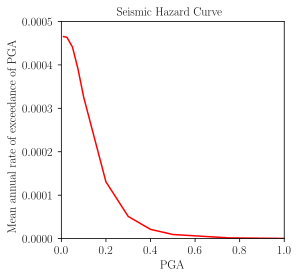

In [28]:
ystar = np.array([0.01,0.025,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.75,1.0])
LAMBDA_Y = []
prob_R = 1.0
for kk in range(0,len(ystar)):
    LAMBDA_Y.append(calc_lambda_y(ystar[kk],prob_M,
                                  prob_R,lambda_param,zeta_param))

fig, ax = plt.subplots(1,1)
fig.set_size_inches(4,4)

plt.plot(ystar,LAMBDA_Y,label='',c='red')

plt.xlim([0,1.0])
plt.ylim([0,0.0005])
plt.ylabel('Mean annual rate of exceedance of PGA')
plt.xlabel('PGA')
plt.title('Seismic Hazard Curve')
plt.show() 